In [1]:
#! sudo apt -qq -y install fonts-nanum

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


In [4]:
import pandas as pd

In [5]:
cache_dir = '~/aiffel/GoingDeeper/DATA/s2s_translation'
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    cache_dir = cache_dir,
    extract=True
    )

In [6]:
path_to_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
path_to_en = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

In [7]:
with open(path_to_ko, "r") as f:
    raw_ko = f.read().splitlines()
with open(path_to_en, "r") as f:
    raw_en = f.read().splitlines()
print("Data Size:({},{})".format(len(raw_ko), len(raw_en)))
print("Example:")

cnt = 0
for ko, en in zip(raw_ko, raw_en):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

step2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

1. 중복 제거

In [8]:
cleaned_corpus = list(set(zip(raw_ko, raw_en))) #정렬 고정
len(cleaned_corpus)

78968

In [9]:
pair_df = pd.DataFrame({'Korean':raw_ko, 'English':raw_en}) #데이터프레임형태로
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [10]:
pair_df.duplicated().sum() #15155개의 중복 존재

15155

In [11]:
pair_df.drop_duplicates(inplace=True)
pair_df.shape #중복제거완료

(78968, 2)

2. preprocessing

In [12]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    
    #- 단어와 구두점(punctuation)사이의 거리 생성
    sentence = re.sub(r"([?.!,])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    # (ㄱ-ㅎ, ㅏ-ㅣ 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip() #- 양쪽 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence #시작토큰

    if e_token:
        sentence += ' <end>' #종료토큰
    
    return sentence

In [13]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    ko, en = pair[0], pair[1]
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("Korean:", enc_corpus[2500])
print("English:", dec_corpus[2500])

Korean: 이 기법을 이용해 연구원들은 유전자 변형을 쥐의 배아줄기세포에 도입했다 .
English: <start> To use this technique , researchers introduce a genetic change into mouse embryonic stem cells . <end>


3. 토큰화

In [14]:
from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
def tokenize(corpus, vocab_size = 30000, maxlen=40, mecab=False):
    
    if mecab:
        mecab = Mecab()
        x_train = []
        for sen in corpus:
            x = mecab.morphs(sen)
            x_train.append(x) #토큰화
        words = np.concatenate(x_train).tolist() #단어사전
        counter = Counter(words)
        counter = counter.most_common(vocab_size) #
        vocab = ['','']+[key for key,_ in counter]
        word_to_index = {word : index for index, word in enumerate(vocab)} #- word : index 사전
        
        #특수토큰 단어 사전 추가
        word_to_index["<PAD>"] = 0
        word_to_index["<UNK>"] = 1
        
        #각 단어를 단어사전인덱스로 변환
        def wordlist_to_indexlist(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
        x_train = list(map(wordlist_to_indexlist, x_train))
        

        index_to_word = {index:word for word, index in word_to_index.items()}
        
        #maxlen길이로 패딩
        x_train = pad_sequences(x_train, 
                        value=word_to_index["<PAD>"],
                        padding='post',
                        maxlen=maxlen)
        
        return x_train, word_to_index

    #영어의경우
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
        tokenizer.fit_on_texts(corpus) #공백 토큰화
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=maxlen, padding='post')
        return tensor, tokenizer

In [16]:
enc_tensor, enc_tokenizer = tokenize(enc_corpus, vocab_size = 30000-2, maxlen=40, mecab=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, vocab_size = 30000+1, maxlen=40, mecab=False)

In [23]:
print("Korean Vocab Size:", len(enc_tokenizer))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 30000
English Vocab Size: 44689


step 4. 모델 설계
- Dropout모듈 추가
- Embedding size, Hidden size 적당한 값

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        # score shape == (batch_size, max_length, 1)
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # attention weights shape == (batch_size, max_length, 1)
        attn = tf.nn.softmax(score, axis=1)
        
        # context vector shape after sum == (batch_size, hidden_size)
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, dropout=0.3, #드롭아웃 추가
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, dropout=0.3, #드롭아웃 추가
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [24]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

In [25]:
# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 44690)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


step 5. 훈련하기

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [27]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [29]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1234/1234 [14:42<00:00,  1.40it/s, Loss 1.4579]


In [33]:
def evaluate(sentence, encoder, decoder):
    mecab = Mecab()
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)
    inputs = [[enc_tokenizer[word] if word in enc_tokenizer else enc_tokenizer["<UNK>"] for word in sentence]]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                        value=enc_tokenizer["<PAD>"],
                        padding='post',
                        maxlen=enc_tensor.shape[-1])
    print(inputs)

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [34]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

[[110, 5, 47, 4, 3, 2]]
[[110   5  47   4   3   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is the president elect barack obama . <end> 


/tmp/ipykernel_73/3883796549.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_73/3883796549.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


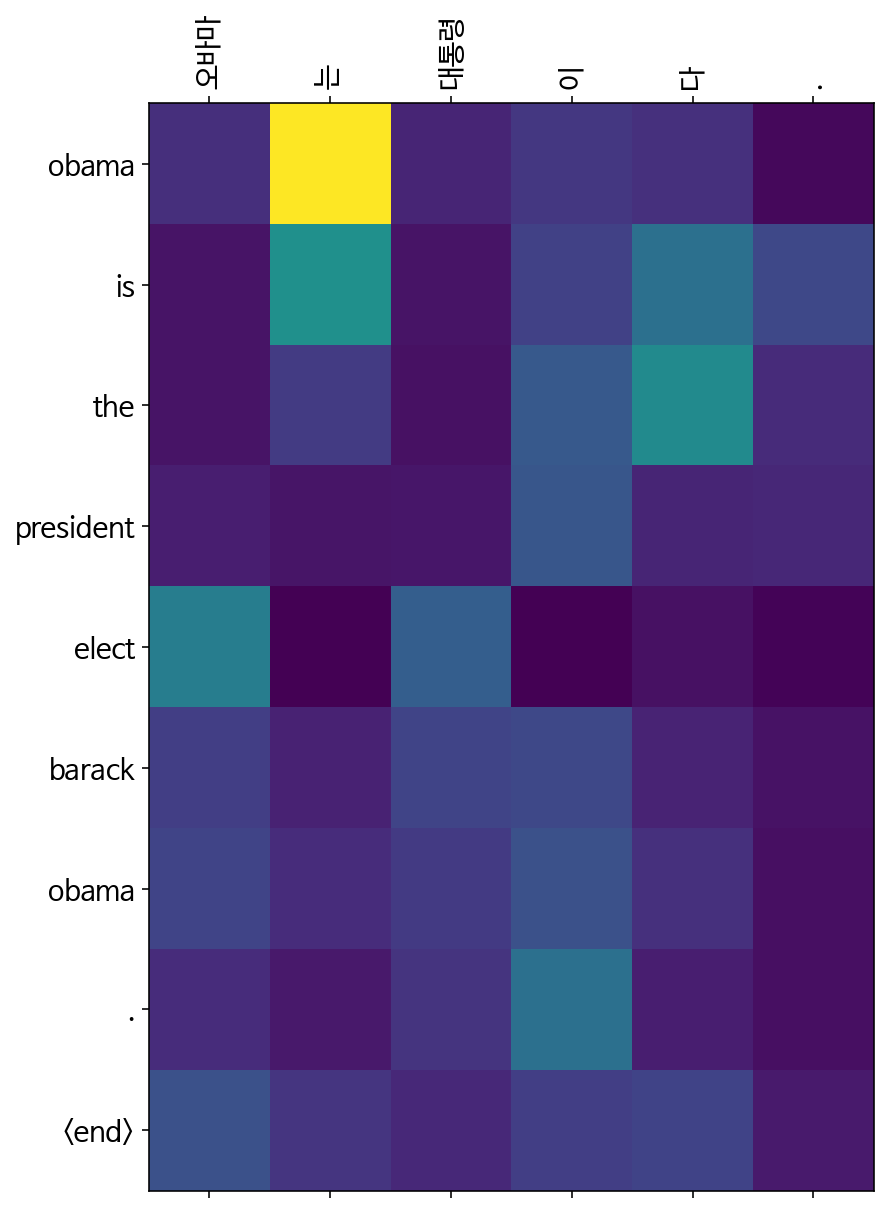

[[514, 15, 9, 322, 578, 8, 1, 2]]
[[514  15   9 322 578   8   1   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they ve got to work in cities . <end> 


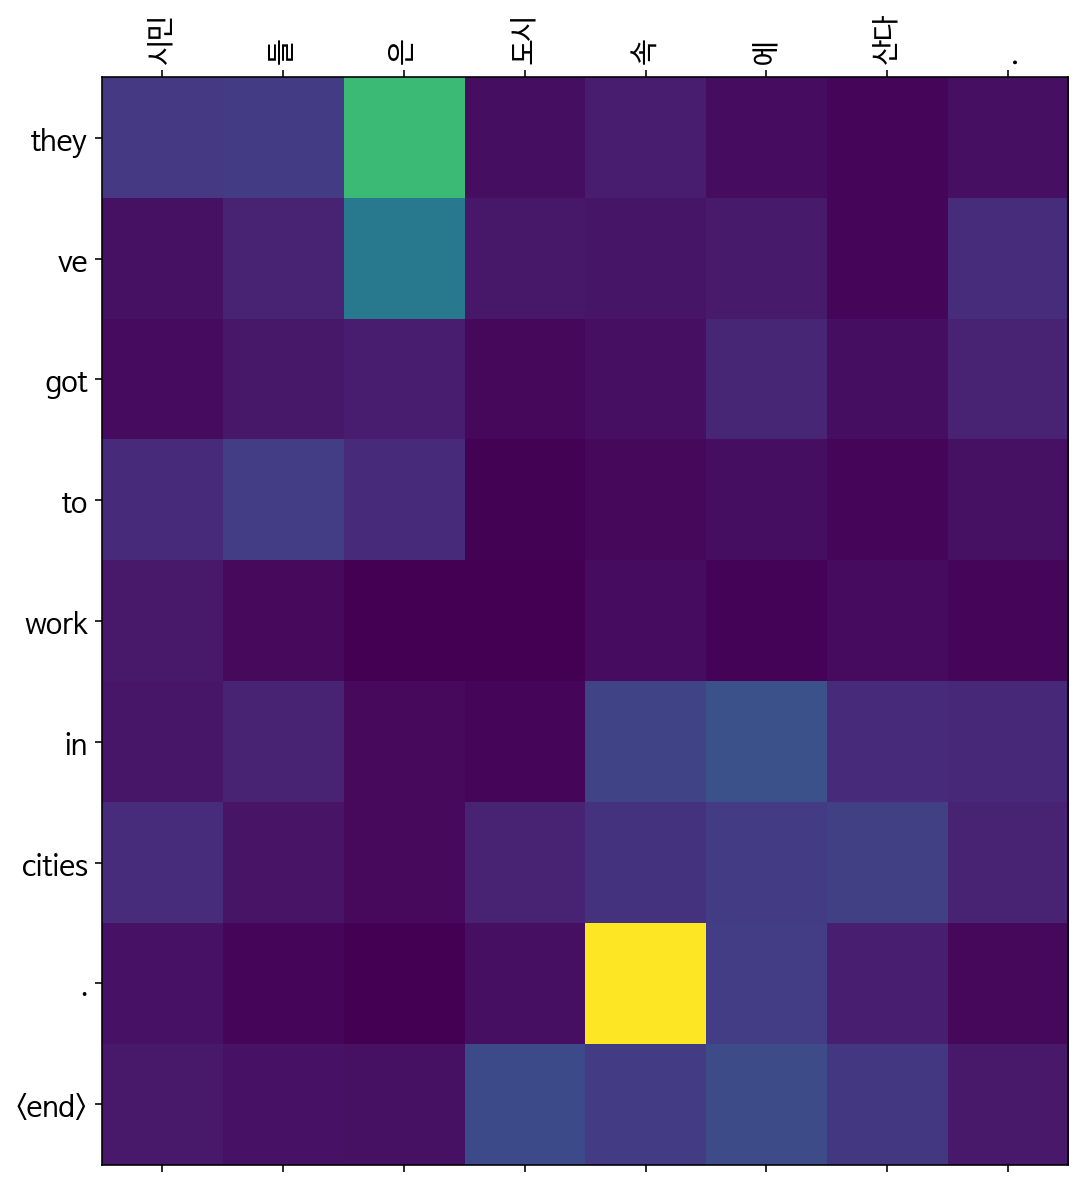

[[2675, 5, 222, 69, 3, 2]]
[[2675    5  222   69    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the economy isn t easy to be a good thing . <end> 


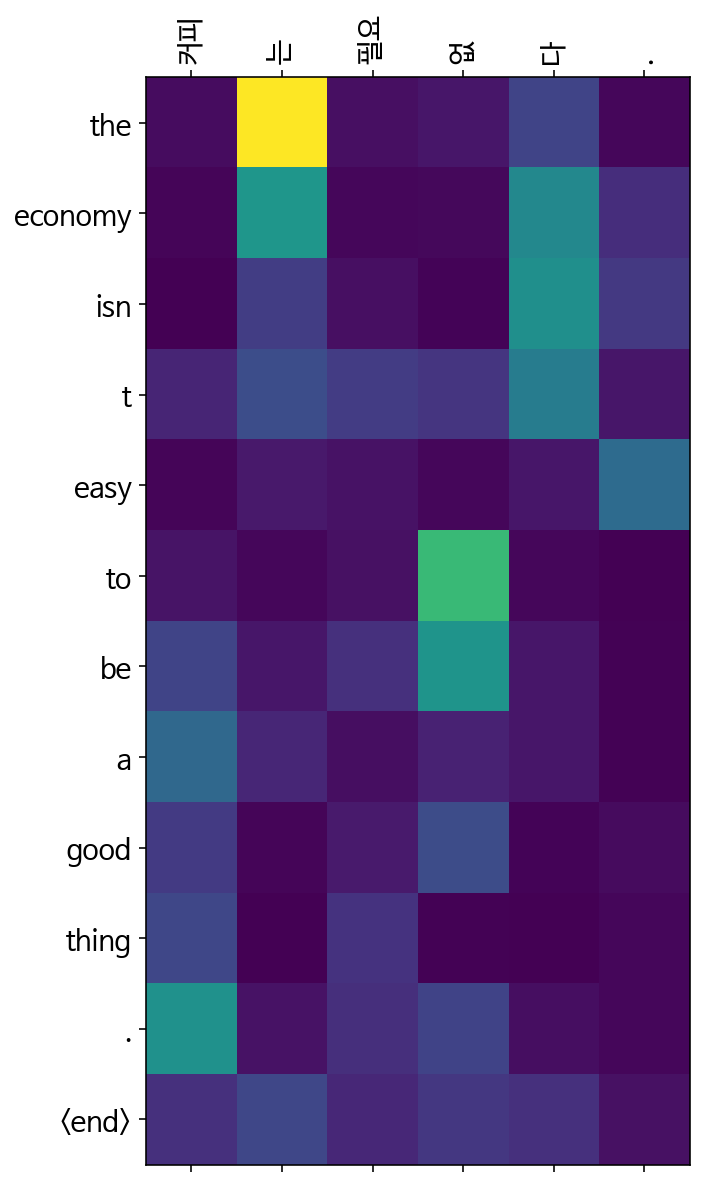

[[6245, 33, 7, 516, 16, 89, 12, 3, 2]]
[[6245   33    7  516   16   89   12    3    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the dead were killed . <end> 


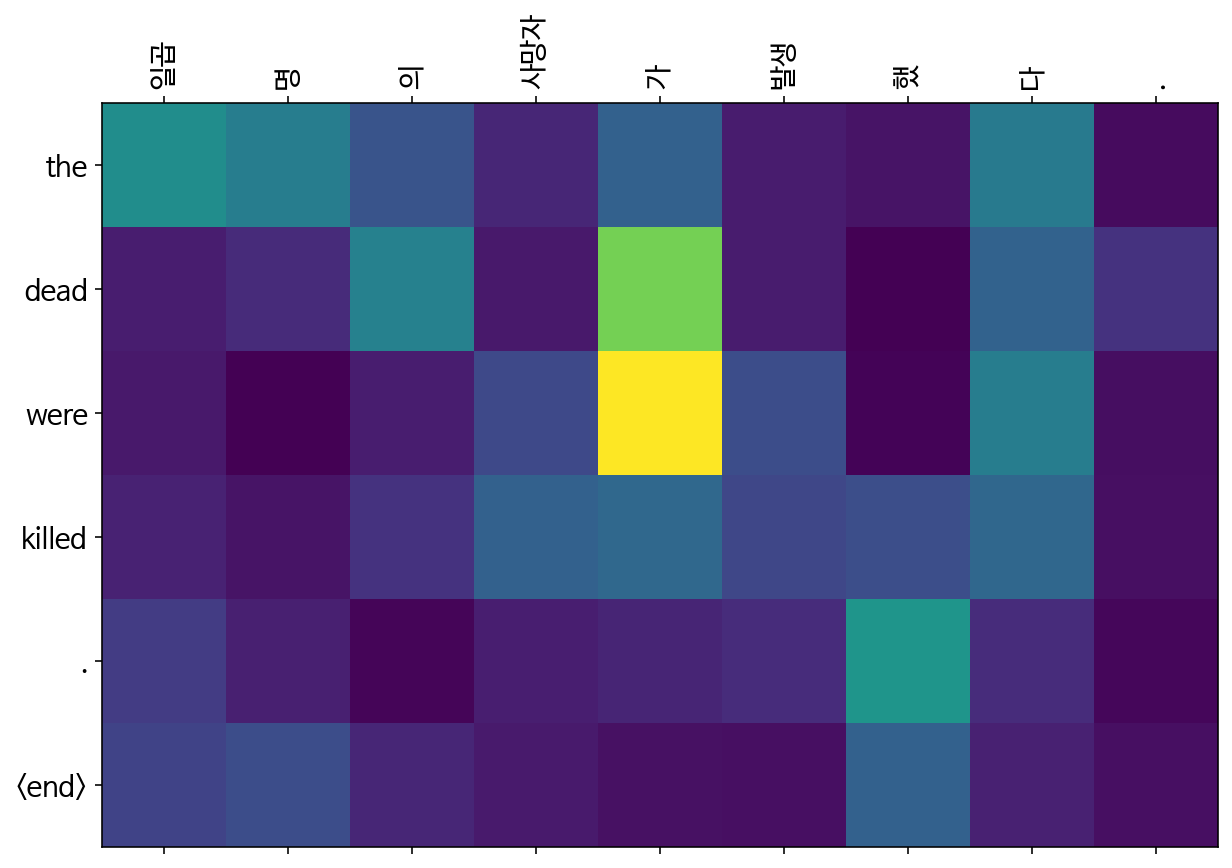

In [35]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

회고
- 배운점 : seq2seq , attention에 대해서 좀 더 심화적으로 학습할 수 있었다.
- 아쉬운 점 : 개념 부분에서 완벽한 이해가 이루어졌는진 모르겠지만..좀 더 다양한 전처리와 실험을 진행하지못한 점이 아쉽다.
- 느낀점 : 드롭아웃만 추가했을 뿐인데 생각보다 번역이 잘된 것 같기도하다..놀랍다
- 어려웠던 점 : 훈련 시간이 길고 한국어 전처리 및 토큰화가 역시나 복잡하고 어렵다.